In [1]:
%%capture
!pip install fastparquet
!pip install pandarallel

In [170]:
import pystan
import numpy as np
import pandas as pd
import pickle
from src.utils import create_output_directories
import seaborn as sns
#Set up parallel processing
from pandarallel import pandarallel
from tqdm.notebook import trange, tqdm
from src.tables import get_table

pandarallel.initialize(nb_workers=8,verbose=True,progress_bar=True)
tqdm.pandas()

#Make sure things reload
%load_ext autoreload
%autoreload 2

root = '.'
pal = sns.color_palette("Set2",n_colors=8)

create_output_directories()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h1>Overview</h1>

Below is the code necessary to recreate the analysis from "Combining interventions to reduce the spread of viral misinformation." This notebook assumes that there is a folder located in "root" (default '.') called "data" containing:
<ol>
<li>Directory: Timeseries with subdirectories:</li>
    <ul>
    <li>aggressive</li>
    <li>modest</li>
    <li>currently</li>
    <li>Verified</li>
    <li>500k, 100k, 50k, 10k</li>
    <li>aggregated</li>
    <li>raw</li>
     </ul>
<li>ban_df_counts.parquet</li>
<li>events.parquet</li>
<li>incidents.parquet</li>
</ol>

Each of the subdirectories should contain aggregated time-series data, downloaded from LINK for each of the unfiltered events. This data were generated from our raw data which is not shared for privacy concerns. However, we include the code used to generate the aggregated time-series for application to novel datasets.


<h1>Segmentation and model fit</h1>

<h2>Segmentation</h2>

We begin by segmenting the time series of incidents into distinct events. Here, we define events as periods of heightened activity, with peaks at least 6 hours apart (i.e. 1 per 12 hours). Events within an incident are included if their peak height is at least 30% of the maximum peak height (parameter pmin for srseg.get_peaks). Begining and end of events are selected when the volume of tweets is less than 5% of tweet height (paramters before_min, after_min in srcseg.get_peaks)

In [378]:
incidents = pd.read_parquet('./data/incidents.parquet')

In [379]:
import src.segmentation as srcseg

def event_df(row):
    peaks = srcseg.get_peaks(row,root='.',start=0, freq=5,pmin=.3,
                      after_min=.05, before_min=.05, distance=6)
    event_dictionaries = []
    for idx, peak in enumerate(peaks):
        one_event = {'incident_name':row['incident_name'],
                     'start':peak[0],
                     'end':peak[1],
                     'event_name':row['incident_name']+'_event_'+str(idx)}
        event_dictionaries.append(one_event)
    return pd.DataFrame(event_dictionaries)


events = pd.concat([pd.DataFrame(item) for item in incidents.T.parallel_apply(event_df,
                                                                     result_type='reduce')])
events = pd.merge(events, incidents, left_on='incident_name', right_on='incident_name')
events = events[(events['end'] - events['start']) >=12]
events.to_parquet(root + '/data/events.parquet',compression=None)
print('Found %s events' % str(events.shape[0]))
_ = events.T.parallel_apply(srcseg.plot_event)

INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Found 260 events


<h2> Fit model to all events </h2>

With events segmented, we turn to evaluating our model fit with regards to each event. Our model, in its simplest form  can be described as: 

\begin{equation}
\label{eq1}
\begin{aligned}
    y_{t} &=  \exp(\alpha + \beta v_{t-1})\\
    v_{t} &= v_{n-1} \delta e^{-\lambda t} + x[t]) \\
    x_{t} &= \log(\sum_{j=1}^{y_t} F_{j})
\end{aligned}
\end{equation}

Where $y_t$ are the tweets at time $t$, $\alpha$ is the baseline rate of discussion, and $\beta$ is the effect of virality, $v$. Virality decays exponentially as a function of $\delta$ and $\lambda$. Here, $\delta$ captures the baseline rate of decay per time step, and $\lambda$ controls the way in which that decay changes over the lifetime of an event. This could either be due to algorithmic processes favoring new content or, for very large events, user saturation. Every time step, for each of $y_t$ accounts, the log sum ($x_t$) of their followers, $F_j$ is added to virality for the subsequent time step. We translate this into a bayesian statistical model such that: 

\begin{align*}
y_{t} &\sim \text{NegativeBinomial2}(\mu_{t}, \phi) \text{ for }t=2...T \\ 
\mu_{i} &= \exp(\alpha + \beta v_{t-1})\text{ for  }t=2...T \\ 
v_{t} &= v_{t-1}\delta e^{-\lambda t} + x_{t} \\
\alpha &\sim \text{Normal}(-3,3) \\
\beta &\sim \text{Normal}(0,3) \\
\delta &\sim \text{Beta}(2,2) \\
\lambda &\sim \text{HalfExponential}(1) \\
\phi &\sim \text{HalfExponential}(1) \\ 
v_{1} &= x_{1}\\
x_{t} &= \log(\sum_{j=1}^{y_t} F_{j}+1)
\end{align*}

This model can be found in /src/timeseries.stan. Because our model makes assumptions about how misinformation cascades spread, it is unlikely to fit everything that is considered an event. Ways in which we can identify a failed fit include parameters not converging, divergent transitions, or the posterior predictive distribution of cascade sizes not containing observed value. Here, we load the model and apply it to each segmented event. We then evaluate inclusion criteria and plot all successfully fitted events for visual inspection. Note that Stan will (and should) yell at us when events fail to fit. This is expected at this stage. 


In [3]:
events = pd.read_parquet(root + '/data/events.parquet')

In [112]:
#Compile model, we only need to do this once. 
model = pystan.StanModel(root + '/src/timeseries.stan')
pickle.dump(model, open(root + '/output/posteriors/model.p','wb'))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a7033beae7425c31157a62d047eae417 NOW.


In [4]:
model = pickle.load(open(root + '/output/posteriors/model.p','rb'))

In [6]:
#Fit model to all events, save them. 
#This will take a while
#We will get some divergent transitions,warnings
#But we're not expecting our model to fit every time series
#That's 
import src.model_fit as srcmf
diagnostics = []
for idx in tqdm(range(events.shape[0])):
    diagnostics.append(srcmf.fit_model(events.iloc[idx],model,keep=False))

  0%|          | 0/260 [00:00<?, ?it/s]

/home/joebak/CombinedPolicy/src/model_fit.py:29: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(samples,


In [19]:
row = events.iloc[3]
import src.model_fit as srcmf
out = events.T.progress_apply(srcmf.check_fit)
events = pd.DataFrame.from_records(out)


  0%|          | 0/260 [00:00<?, ?it/s]

--------
voting_machines_7_event_0
--------
voting_machines_7_event_1
--------
ballot_stuffing_1_event_0
--------
destroyed_ballots_1_event_0
--------
ballot_harvesting_3_event_0
--------
voting_machines_2_event_0


--------
ballot_dumping3_event_0
--------
ballot_dumping3_event_1
--------
ballot_dumping3_event_2
--------
dhs_watermarks_1_event_0


--------
protests_3_event_0
--------
partisan_counting_3_event_0
--------
rejection_rates_1_event_0
--------
protests1_event_0


--------
missing_found_ballots_2_event_0
--------
premature_victory_6_event_0
--------
ballot_chasers_1_event_0
--------
ballot_chasers_1_event_1
--------
ballot_counting_2_event_0
--------
bad_statistics_6_event_0
--------
violence_at_polling_place_1_event_0
--------
fake_IDs_1_event_0


--------
fake_IDs_1_event_1
--------
fake_IDs_1_event_2


--------
fake_IDs_1_event_3
--------
fake_IDs_1_event_4
--------
poll_watchers_4_event_0


--------
poll_watchers_2_event_0
--------
poll_watchers_2_event_1
--------
poll_watchers_2_event_2


--------
more_votes_than_registered_1_event_0
--------
voting_twice3_event_0


--------
voting_twice3_event_1
--------
voting_twice3_event_2
--------
voting_twice3_event_3


--------
voting_twice3_event_4
--------
voting_twice3_event_5
--------
poll_watchers_10_event_0


--------
partisanship_at_polling_places_3_event_0


--------
ballot_counting_1_event_0
--------
ballot_dumping6_event_0
--------
ballot_dumping6_event_1
--------
ballot_dumping6_event_2
--------
voting_twice5_event_0
--------
voting_twice5_event_1
--------
voting_twice5_event_2


--------
poll_watchers_8_event_0
--------
color_revolution_1_event_0


--------
color_revolution_1_event_1
--------
color_revolution_1_event_2
--------
color_revolution_1_event_3


--------
color_revolution_1_event_4
--------
color_revolution_1_event_5
--------
color_revolution_1_event_6
--------
color_revolution_1_event_7


--------
color_revolution_1_event_8
--------
color_revolution_1_event_9
--------
color_revolution_1_event_10
--------
color_revolution_1_event_11
--------
color_revolution_1_event_12
--------
partisanship_at_polling_places_2_event_0
--------
premature_victory_3_event_0


--------
dead_voters_1_event_0
--------
stolen_ballots4_event_0
--------
premature_victory_5_event_0
--------
i_did_fraud_1_event_0
--------
i_did_fraud_1_event_1


--------
vote_counting_videos_6_event_0
--------
vote_counting_videos_2_event_0
--------
partisan_counting_1_event_0
--------
out_of_context_content_2_event_0
--------
ballot_box_issues_2_event_0
--------
ballot_box_issues_2_event_1
--------
premature_victory_2_event_0


--------
premature_victory_2_event_1
--------
missing_found_ballots_1_event_0
--------
missing_found_ballots_1_event_1
--------
missing_found_ballots_5_event_0
--------
dead_voters_3_event_0
--------
bad_statistics_4_event_0
--------
bad_statistics_4_event_1
--------
stolen_ballots1_event_0
--------
intimidation_8_event_0
--------
intimidation_8_event_1
--------
intimidation_8_event_2
--------
intimidation_8_event_3


--------
intimidation_8_event_4
--------
intimidation_2_event_0
--------
whistleblower_2_event_0
--------
whistleblower_2_event_1


--------
whistleblower_2_event_2
--------
whistleblower_2_event_3


--------
whistleblower_2_event_4
--------
whistleblower_2_event_5
--------
stolen_ballots2_event_0
--------
stolen_ballots2_event_1
--------
late_ballots_3_event_0
--------
late_ballots_3_event_1
--------
voting_twice2_event_0
--------
poll_watchers_9_event_0
--------
mail-in_voting_1_event_0
--------
mail-in_voting_1_event_1
--------
missing_found_ballots_4_event_0
--------
missing_found_ballots_4_event_1


--------
missing_found_ballots_4_event_2
--------
bad_statistics_3_event_0
--------
bad_statistics_3_event_1


--------
ballot_dumping4_event_0
--------
ballot_dumping4_event_1
--------
Hammer_and_scorecard_1_event_0
--------
Hammer_and_scorecard_1_event_1
--------
texas_political_director_fraud1_event_0
--------
texas_political_director_fraud1_event_1


--------
texas_political_director_fraud1_event_2
--------
premature_victory_4_event_0


--------
poll_watchers_6_event_0
--------
vote_count_jumps_1_event_0
--------
intimidation_3_event_0
--------
intimidation_3_event_1
--------
intimidation_3_event_2
--------
missing_found_ballots_3_event_0
--------
Trump_delegtimization_3_event_0


--------
bad_statistics_1_event_0


--------
misprinted_ballots_3_event_0
--------
misprinted_ballots_3_event_1
--------
misprinted_ballots_3_event_2
--------
whistleblower_4_event_0
--------
whistleblower_4_event_1
--------
protests_2_event_0
--------
vague_fraud_1_event_0


--------
vague_fraud_1_event_1
--------
ballot_dumping5_event_0


--------
ballot_dumping5_event_1
--------
ballot_dumping5_event_2
--------
ballot_dumping5_event_3
--------
ballot_dumping5_event_4


--------
whistleblower_1_event_0


--------
partisan_counting_2_event_0
--------
late_ballots_1_event_0
--------
cancelled_ballot_1_event_0
--------
cancelled_ballot_1_event_1
--------
voting_machines_4_event_0
--------
vote_count_jumps_2_event_0
--------
vote_count_jumps_2_event_1
--------
partisan_counting_4_event_0
--------
partisan_counting_4_event_1
--------
livestream_1_event_0
--------
livestream_1_event_1
--------
livestream_1_event_2
--------
livestream_1_event_3
--------
granny_farming_1_event_0
--------
granny_farming_1_event_1
--------
granny_farming_1_event_2
--------
vote_counting_videos_5_event_0


--------
stolen_polling_materials1_event_0
--------
stolen_polling_materials1_event_1


--------
bad_statistics_7_event_0
--------
bad_statistics_7_event_1


--------
late_ballots_2_event_0
--------
late_ballots_2_event_1
--------
ballot_dumping1_event_0
--------
misprinted_ballots_2_event_0
--------
misprinted_ballots_2_event_1
--------
misprinted_ballots_2_event_2
--------
ballot_harvesting2_event_0
--------
ballot_harvesting2_event_1


--------
sharpiegate_1_event_0
--------
ballot_signatures_1_event_0
--------
ballot_signatures_1_event_1
--------
ballot_signatures_1_event_2
--------
urban_playbook_1_event_0
--------
dead_voters_4_event_0


--------
dead_voters_4_event_1
--------
dead_voters_4_event_2


--------
dead_voters_4_event_3
--------
dead_voters_4_event_4
--------
dead_voters_4_event_5
--------
usps_missing_ballots_1_event_0


--------
shredded_ballot_applications1_event_0
--------
vote_buying2_event_0


--------
incorrect_voting_info_1_event_0
--------
incorrect_voting_info_1_event_1


--------
Biden_clip_saying_he_does_fraud_1_event_0


--------
stopthesteal_1_event_0
--------
vote_counting_videos_4_event_0
--------
resident_fraud_2_event_0
--------
out_of_context_content_4_event_0
--------
out_of_context_content_3_event_0


--------
out_of_context_content_3_event_1
--------
shredded_ballot_applications_1_event_0
--------
voting_machines_5_event_0
--------
ballot_dumping_8_event_0
--------
ballot_dumping_8_event_1
--------
ballot_dumping_8_event_2


--------
ballot_dumping_8_event_3
--------
violence_at_polling_place_2_event_0


--------
Trump_delegtimization_1_event_0
--------
vote_counting_videos_3_event_0


--------
vote_counting_videos_3_event_1
--------
hacks_2_event_0
--------
hacks_2_event_1
--------
hacks_2_event_2


--------
hacks_2_event_3
--------
hacks_2_event_4
--------
hacks_2_event_5
--------
hacks_2_event_6
--------
hacks_2_event_7
--------
ballot_dumping2_event_0
--------
ballot_dumping2_event_1
--------
polling_stations_1_event_0


--------
chinese_ballots_1_event_0


--------
chinese_ballots_1_event_1
--------
ballot_signatures_2_event_0
--------
poll_watchers_1_event_0


--------
intimidation_1_event_0
--------
voting_machines_1_event_0
--------
voting_twice1_event_0


--------
coup_1_event_0
--------
coup_1_event_1
--------
coup_1_event_2
--------
misprinted_ballots_1_event_0
--------
destroyed_ballots_2_event_0
--------
hacks_1_event_0


--------
voting_machines_3_event_0
--------
voting_machines_3_event_1


--------
voting_machines_3_event_2
--------
vote_changing1_event_0
--------
pre-filled_ballots_1_event_0
--------
poll_watchers_5_event_0
--------
poll_watchers_5_event_1
--------
poll_watchers_5_event_2
--------
bad_statistics_5_event_0


--------
bad_statistics_5_event_1


--------
ballot_harvesting_1_event_0
--------
intimidation_6_event_0
--------
drive-through_voting_1_event_0
--------
drive-through_voting_1_event_1
--------
drive-through_voting_1_event_2


--------
vote_counting_videos_1_event_0
--------
vote_counting_videos_1_event_1


--------
vote_buying1_event_0
--------
vote_buying1_event_1


--------
poll_watchers_3_event_0
--------
dead_voters_6_event_0


--------
intimidation_5_event_0
--------
whistleblower_3_event_0
--------
ballot_dumping_7_event_0
--------
ballot_dumping_7_event_1
--------
partisanship_at_polling_places_1_event_0


--------
partisanship_at_polling_places_1_event_1
--------
rejection_rates_2_event_0
--------
rejection_rates_2_event_1


--------
rejection_rates_2_event_2
--------
poll_watchers_7_event_0
--------
voting_machines_6_event_0
--------
voting_machines_6_event_1
--------
resident_fraud_1_event_0
--------
intimidation_7_event_0
--------
stolen_ballots3_event_0
--------
stolen_ballots3_event_1


<h3>Evaluate Inclusion</h3>

In [126]:
events['included'] = (events['Rhat'] & events['final_predicted'] & events['divergence'] \
                      &(events['end']-events['start'] > 12))
print('Included %s events, %s percent of total' % (str(events['included'].sum()), 
                                           str(100*np.mean(events['included']))))
print('Total tweets: %s' % str(np.sum(events['observed_engagement'])))
events.to_parquet('./data/events_fitted.parquet',compression=None)

Included 220 events, 84.61538461538461 percent of total
Total tweets: 8417986.0


<h3>Plot figures for review and SI</h3>

In [3]:
events = pd.read_parquet('./data/events_fitted.parquet')

In [10]:
from src.figures import plot_posterior_and_save
_ =events.T.parallel_apply(plot_posterior_and_save,keep=False)

In [ ]:
from src.figures import SI_Posterior
import seaborn as sns
# gridspec inside gridspec
sns.set_style('white')
included = events[events['included']]
SI_Posterior(included)


<h1>Simulations and output</h1>

Now that we have parameter estimates for all included events, we can use these parameters to simulate engagement while varying parameters. Our simulations (code in src.simulation.py) seed the first time-step with actual data. Beginning on the second time step, we estimate the number of new users that will share the content. We then draw follower counts from the observed follower counts at that time step in the data. The log of the sum of follower counts is added to the virality which is used in the subsequent time step to predict retweets. This processes is repeated for the length of the observed event. We repeat this for all events, normalizing time on a 0-1 scale and summing the posteriori distributions to evaluate engagement. 

There's a wall of code ahead, but most of it is specifying the parameters for the simuations. This is accomplished with two dataframes. *included* specifies parmaters related a given event, and *sim_df* specifies the paramters for a given simulation of all events. We start by definining a baseline condition where no parameters of the model are altered and the aggregated data used includes all follower (i.e. from /data/timeseries/aggregated). We then modify this entry for various conditions either pointing the simulation to a different set of aggregated data with removed users, altering nudges, or implementing various removal and virality circuit breakers. This code should be expected to take a couple of hours with 8 cores and 500 simulations per event per condition (110000 total). 

The nice thing about this approach is that we can just send the rows we care about to the plotting function and get out the plots we want. Be careful when specifying which rows to be sure you're getting the right one. The nice thing is that by color coding conditions in the dataframe, it's pretty easy to see when you've snagged a wrong one. When in doubt, check *sim_df.iloc[[list_of_rows]]*. As we lack our color check when making tables, we're going to generate them along with figures just for a little safety. 


<h2>Define and run simulations</h2>

In [130]:
events = pd.read_parquet('./data/events_fitted.parquet')
included = events[events['included']]
#This gets rid of an obnoxious warning
pd.options.mode.chained_assignment = None  # default='warn'

included['start'] = included['start'].astype('int')
included['end'] = included['end'].astype('int')

In [375]:
#We need to add new columns so we can tell the simulation where to find
#aggregated files with certain thresholds of 3-strikes repeat offenders
#removed. 

#This gets rid of an obnoxious warning
pd.options.mode.chained_assignment = None  # default='warn'

included['data_loc']
base_loc = root + '/data/timeseries'
assign_data_location = lambda x: [x + str(item) + '_raw.parquet' for item in included['incident_name'].values]

included['10K_loc'] = assign_data_location(base_loc + '/10K/')
included['50K_loc']  = assign_data_location(base_loc + '/50K/')
included['100K_loc']  = assign_data_location(base_loc + '/100K/')
included['500K_loc']  = assign_data_location(base_loc + '/500K/')
included['aggregated_loc']  = assign_data_location(base_loc + '/aggregated/')
included['currently_loc']  = assign_data_location(base_loc + '/currently/')
included['verified_loc']  = assign_data_location(base_loc + '/Verified/')
included['modest_loc']  = assign_data_location(base_loc + '/modest/')
included['aggressive_loc']  = assign_data_location(base_loc + '/aggressive/')

included.head()


,n_eff,Rhat,divergence,treedepth,energy,observed_engagement,y_0,final_predicted,incident_name,start,...,included,10K_loc,50K_loc,100K_loc,500K_loc,aggregated_loc,currently_loc,verified_loc,modest_loc,aggressive_loc
0,True,True,True,True,True,9291.0,44.0,True,voting_machines_7,375,...,True,./data/timeseries/10K/voting_machines_7_raw.pa...,./data/timeseries/50K/voting_machines_7_raw.pa...,./data/timeseries/100K/voting_machines_7_raw.p...,./data/timeseries/500K/voting_machines_7_raw.p...,./data/timeseries/aggregated/voting_machines_7...,./data/timeseries/currently/voting_machines_7_...,./data/timeseries/Verified/voting_machines_7_r...,./data/timeseries/modest/voting_machines_7_raw...,./data/timeseries/aggressive/voting_machines_7...
1,True,True,True,True,True,1681.0,4.0,True,voting_machines_7,532,...,True,./data/timeseries/10K/voting_machines_7_raw.pa...,./data/timeseries/50K/voting_machines_7_raw.pa...,./data/timeseries/100K/voting_machines_7_raw.p...,./data/timeseries/500K/voting_machines_7_raw.p...,./data/timeseries/aggregated/voting_machines_7...,./data/timeseries/currently/voting_machines_7_...,./data/timeseries/Verified/voting_machines_7_r...,./data/timeseries/modest/voting_machines_7_raw...,./data/timeseries/aggressive/voting_machines_7...
2,True,True,True,True,True,18376.0,12.0,True,ballot_stuffing_1,244,...,True,./data/timeseries/10K/ballot_stuffing_1_raw.pa...,./data/timeseries/50K/ballot_stuffing_1_raw.pa...,./data/timeseries/100K/ballot_stuffing_1_raw.p...,./data/timeseries/500K/ballot_stuffing_1_raw.p...,./data/timeseries/aggregated/ballot_stuffing_1...,./data/timeseries/currently/ballot_stuffing_1_...,./data/timeseries/Verified/ballot_stuffing_1_r...,./data/timeseries/modest/ballot_stuffing_1_raw...,./data/timeseries/aggressive/ballot_stuffing_1...
3,True,True,True,True,True,34136.0,20.0,True,destroyed_ballots_1,19,...,True,./data/timeseries/10K/destroyed_ballots_1_raw....,./data/timeseries/50K/destroyed_ballots_1_raw....,./data/timeseries/100K/destroyed_ballots_1_raw...,./data/timeseries/500K/destroyed_ballots_1_raw...,./data/timeseries/aggregated/destroyed_ballots...,./data/timeseries/currently/destroyed_ballots_...,./data/timeseries/Verified/destroyed_ballots_1...,./data/timeseries/modest/destroyed_ballots_1_r...,./data/timeseries/aggressive/destroyed_ballots...
4,True,True,True,True,True,7950.0,0.0,True,ballot_harvesting_3,592,...,True,./data/timeseries/10K/ballot_harvesting_3_raw....,./data/timeseries/50K/ballot_harvesting_3_raw....,./data/timeseries/100K/ballot_harvesting_3_raw...,./data/timeseries/500K/ballot_harvesting_3_raw...,./data/timeseries/aggregated/ballot_harvesting...,./data/timeseries/currently/ballot_harvesting_...,./data/timeseries/Verified/ballot_harvesting_3...,./data/timeseries/modest/ballot_harvesting_3_r...,./data/timeseries/aggressive/ballot_harvesting...


<h3>

In [193]:
#This is our baseline dictionary which we modify for various conditions. 
#Doing so ensures that we do not inadvertently set a parameter off baseline. 
baseline = dict(name='baseline',
                plot='All',
                num_sims=500,
                data_location = 'data_loc',
                nudge=1, 
                color=np.array([.15,.15,.15]),
                stop_at=np.inf, 
                decay_value=1,
                vcb_value=1, 
                decay_start=np.inf, 
                p_decay=0,
                p_remove = 0,
                freq=5)
#Add removal at various delays
recs = [baseline]
stops = [15,30,60,120,240]
stop_palette = np.array(sns.dark_palette(pal[0], reverse=True, n_colors=len(stops)+1))[1:]
for idx in range(len(stops)):
    add_row = baseline.copy()
    add_row['p_decay'] = 1
    add_row['p_remove'] = 1
    add_row['decay_start'] = stops[idx]
    add_row['stop_at'] = stops[idx]
    add_row['color'] = stop_palette[idx]
    add_row['name'] = 'removal_' + str(stops[idx])
    recs.append(add_row)

#Add probababilistic removal 
for idx in range(len(stops)):
    add_row = baseline.copy()
    add_row['p_decay'] = 1
    add_row['p_remove'] = .2
    add_row['decay_start'] = stops[idx]
    add_row['stop_at'] = stops[idx]
    add_row['color'] = stop_palette[idx]
    add_row['name'] = 'prob_removal_' + str(stops[idx])
    recs.append(add_row)
    
#Add virality circuit breaker applied to all posts
vcb_palette = np.array(sns.dark_palette(pal[-3], reverse=True, n_colors=len(stops)+1))[1:]

for idx in range(len(stops)):
    add_row = baseline.copy()
    add_row['p_decay'] = 1
    add_row['decay_start'] = stops[idx]
    add_row['vcb_value'] = .9
    add_row['color'] = vcb_palette[idx]
    add_row['name'] = 'vcb_' + str(stops[idx])
    recs.append(add_row)
    
#Add virality circuit breaker applied probabalistically 
vcb_palette = np.array(sns.dark_palette(pal[-3], reverse=True, n_colors=len(stops)+1))[1:]
for idx in range(len(stops)):
    add_row = baseline.copy()
    add_row['p_decay'] = .2
    add_row['decay_start'] = stops[idx]
    add_row['vcb_value'] = .9
    add_row['color'] = vcb_palette[idx]
    add_row['name'] = 'prob_vcb_' + str(stops[idx])
    recs.append(add_row)
    
#Add nudges
nudges = [.95,.9,.8,.6]
nudge_palette = sns.dark_palette(pal[2], reverse=False, n_colors=len(nudges)+1)[1:]
for idx in range(len(nudges)):
    add_row = baseline.copy()
    add_row['nudge'] = nudges[idx]
    add_row['color'] = nudge_palette[idx]
    add_row['name'] = 'nudge_' + str(nudges[idx])
    recs.append(add_row)
    


#Add bans
bans=['10K_loc','50K_loc','100K_loc','500K_loc'][::-1]
ban_palette = sns.dark_palette(pal[1], reverse=False, n_colors=len(nudges)+1)[1:]
for idx in range(len(bans)):
    add_row = baseline.copy()
    add_row['data_location'] = bans[idx]
    add_row['color'] = ban_palette[idx]
    add_row['name'] = 'bans_' + str(bans[idx].split('_')[0])
    recs.append(add_row)

bans=['verified_loc','currently_loc']
ban_palette = [np.array([29,161,242])/255.0, pal[1]]
for idx in range(len(bans)):
    add_row = baseline.copy()
    add_row['data_location'] = bans[idx]
    add_row['color'] = ban_palette[idx]
    add_row['name'] = 'bans_' + str(bans[idx].split('_')[0])
    recs.append(add_row)


#Add modest combined simulation
add_row = baseline.copy()
add_row['p_decay'] = .05
add_row['p_remove'] = .2
add_row['decay_start'] = 120
add_row['stop_at'] = 240
add_row['vcb_value'] = .9
add_row['nudge'] = .9
add_row['data_location'] = 'modest_loc'
add_row['color'] = pal[-4]
add_row['name'] = 'modest_0'
recs.append(add_row)

      
    
#Add decay only version of modest policy
add_row = baseline.copy()
add_row['p_decay'] = .05
add_row['p_remove'] = .2
add_row['decay_start'] = 120
add_row['stop_at'] = 240
add_row['vcb_value'] = .9
add_row['color'] = pal[-3]
add_row['name'] = 'modest_decay_only'
recs.append(add_row)


#Add nudge only version of modest policy 
add_row = baseline.copy()
add_row['nudge'] = .9
add_row['color'] = pal[2]
add_row['name'] = 'modest_nudge_only'
recs.append(add_row)

#Add ban only version of modest policy 
add_row = baseline.copy()
add_row['data_location'] = 'modest_loc'
add_row['color'] = pal[1]
add_row['name'] = 'modest_ban_only'
recs.append(add_row)

#Add aggressive combined simulation
add_row = baseline.copy()
add_row['p_decay'] = .10
add_row['p_remove'] = .2
add_row['decay_start'] = 60
add_row['stop_at'] = 120
add_row['vcb_value'] = .8
add_row['nudge'] = .8
add_row['data_location'] = 'aggressive_loc'
add_row['color'] = pal[-4]
add_row['name'] = 'aggressive_0'
recs.append(add_row)


#Add decay only version of aggressive policy
add_row = baseline.copy()
add_row['p_decay'] = .10
add_row['p_remove'] = .2
add_row['decay_start'] = 60
add_row['stop_at'] = 120
add_row['vcb_value'] = .8
add_row['color'] = pal[-3]
add_row['name'] = 'aggressive_decay_only'
recs.append(add_row)

    


#Add nudge only version of aggressive policy 
add_row = baseline.copy()
add_row['nudge'] = .8
add_row['color'] = pal[2]
add_row['name'] = 'aggressive_nudge_only'
recs.append(add_row)



#Add ban only version of aggressive policy 
add_row = baseline.copy()
add_row['data_location'] = 'aggressive_loc'
add_row['color'] = pal[1]
add_row['name'] = 'aggressive_ban_only'
recs.append(add_row)

#Add Combined policy

 
#['aggregated_loc','currently_loc','verified_loc']
   
    
sim_df = pd.DataFrame.from_records(recs)
from src.simulation import sim_row

#temp = sim_row(sim_df.iloc[0],included)
sim_df.to_csv('./output/simulations/sim_df', compression=None)
#The keep parameter tells the simulations whether to re-run old simulations (False)
#or keep them. This is very useful if your notebook dies. Just set it to True
#and the simulations will pick up where they left off. 
sim_included = lambda row: sim_row(row, included,verbose=True,keep=True)
_ = sim_df.T.parallel_apply(sim_included)


[autoreload of src.tables failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/opt/conda/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/opt/conda/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 779, in exec_module
  File "<frozen importlib._bootstrap_external>", line 916, in get_code
  File "<frozen importlib._bootstrap_external>", line 846, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/joebak/CombinedPolicy/src/tables.py", line 29
    outrows.append({

In [26]:
import matplotlib.pyplot as plt
import string
%matplotlib inline

<h2>Figures and Tables</h2>

<h3>Figure 1</h3>

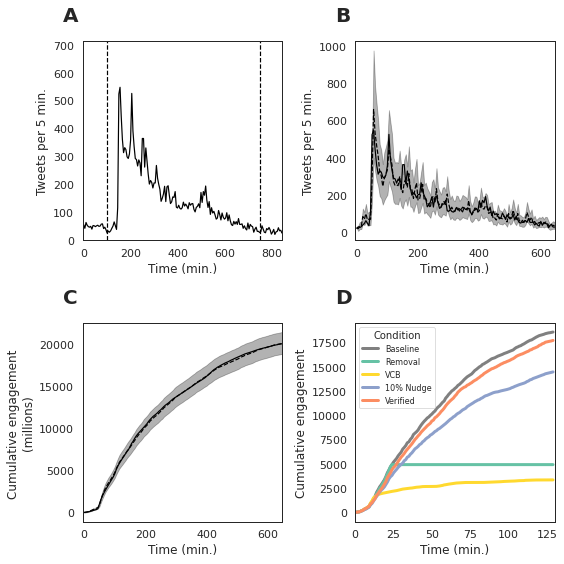

In [455]:
sns.set_context('paper',font_scale=1.25)
sns.set_style('white')

#A not quite random event
#If it breaks when you try a random one it's because
#Figure A adds rows before and after the event
#which isn't possible for all events. 
row_loc = 93
row = included.iloc[row_loc]

from src.figures import plot_figure_1
#The code for figure 1 is a bit messy. 
#The simulations and plotting for individual events
#Is a little duct-tapey. 
plot_figure_1(row, included,pal,root='.')
plt.savefig('./output/figures/MS/Fig1.png')

<h3>Figure 2</h3>

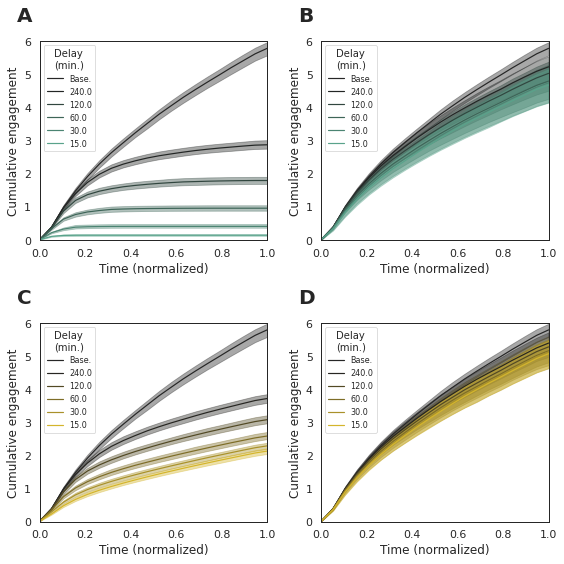

In [210]:
from src.figures import plot_sims
from src.tables import get_table
sns.set_context('paper',font_scale=1.25)
sns.set_style('white')

fig, axs = plt.subplots(2,2,figsize=(8,8))
axs = axs.flat

for n, ax in enumerate(axs):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')
    
plt.sca(axs[0])
order = [0,5,4,3,2,1]
table = get_table(sim_df, order)
table.to_latex('./output/tables/full_removal.tex',index=False)

plot_sims(order, sim_df, 'Delay\n(min.)', 'stop_at')

plt.sca(axs[1])
order = [0,10,9,8,7,6]
table = get_table(sim_df, order)
table.to_latex('./output/tables/partial_removal.tex',index=False)

plot_sims(order, sim_df, 'Delay\n(min.)', 'stop_at')

plt.sca(axs[2])
order = [0,15,14,13,12,11]
table = get_table(sim_df, order)
table.to_latex('./output/tables/full_vcb.tex',index=False)

plot_sims(order, sim_df, 'Delay\n(min.)', 'decay_start')

plt.sca(axs[3])
order = [0,20,19,18,17,16]
table = get_table(sim_df, order)
table.to_latex('./output/tables/partial_vcb.tex',index=False)
plot_sims(order, sim_df, 'Delay\n(min.)', 'decay_start')

plt.tight_layout()
plt.savefig('./output/figures/MS/Fig2.png',dpi=1000)

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


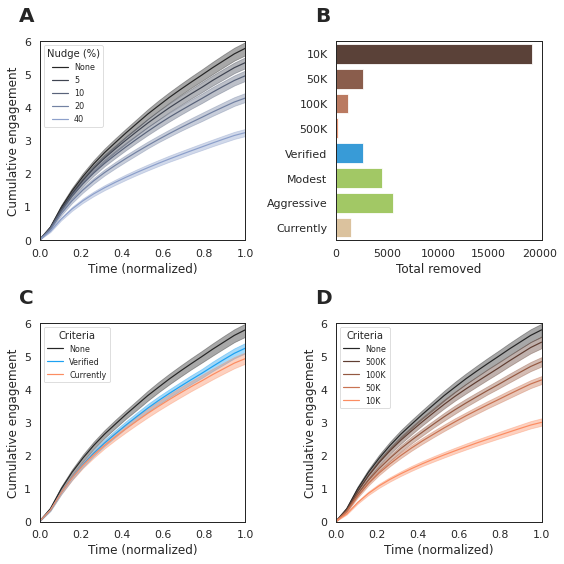

In [211]:
from src.figures import plot_sims
from src.tables import get_table
sns.set_context('paper',font_scale=1.25)
sns.set_style('white')
fig, axs = plt.subplots(2,2,figsize=(8,8))
axs = axs.flat

for n, ax in enumerate(axs):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')
    
plt.sca(axs[0])
order = [0,21,22,23,24]

table = get_table(sim_df, order)
table.to_latex('./output/tables/nudge.tex',index=False)

plot_sims(order, sim_df, 'Nudge', 'nudge')
labels = (100-100*sim_df.iloc[order]['nudge'].values).astype('int').tolist()
labels[0] = 'None'
legend = plt.legend(labels=labels,title='Nudge (%)',loc=2,prop={'size': 8})
legend.get_title().set_fontsize('10')

plt.sca(axs[1])
ban_df = pd.read_parquet(root + '/data/ban_df_counts.parquet')
temp_pal = sns.dark_palette(pal[1], reverse=False, n_colors=len(nudges)+1)[1:]
temp_pal.append( np.array([29,161,242])/255.0)
temp_pal.append(np.array(pal[-4]))
temp_pal.append(pal[-4])
temp_pal.append(pal[6])

sns.barplot(ban_df['Total removed'],
            ban_df['Policy'], palette=temp_pal)
plt.ylabel('')

plt.sca(axs[2])
order = [0,29,30]
table = get_table(sim_df, order)
table.to_latex('./output/tables/ban_current_verified.tex',index=False)

plot_sims(order, sim_df, 'Threshold', 'nudge')
labels = ['Baseline', 'Verified', 'Currently']
labels[0] = 'None'
legend = plt.legend(labels=labels,title='Criteria',loc=2,prop={'size': 8})
legend.get_title().set_fontsize('10')


plt.sca(axs[3])
order = [0,25,26,27,28]
table = get_table(sim_df, order)
table.to_latex('./output/tables/ban_threshold.tex',index=False)

plot_sims(order, sim_df, 'Threshold', 'nudge')
labels = ['Base', '500K', '100K', '50K', '10K']
labels[0] = 'None'
legend = plt.legend(labels=labels,title='Criteria',loc=2,prop={'size': 8})
legend.get_title().set_fontsize('10')

plt.tight_layout()
plt.savefig('./output/figures/MS/Fig3.png',dpi=1000)

<h3>Figure 3</h3>

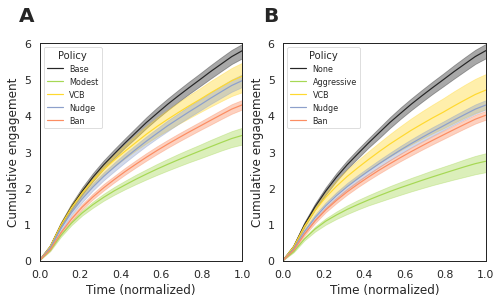

In [213]:
sns.set_context('paper',font_scale=1.25)
sns.set_style('white')
fig, axs = plt.subplots(1,2,figsize=(8,4))
axs = axs.flat

for n, ax in enumerate(axs):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')
    
plt.sca(axs[0])   
order = [0,31,32,33,34]
table = get_table(sim_df, order)
table.to_latex('./output/tables/modest.tex',index=False)

plot_sims(order, sim_df, 'Threshold', 'nudge')
labels = ['Base', 'Modest', 'VCB', 'Nudge', 'Ban']
legend = plt.legend(labels=labels,title='Policy',loc=2,prop={'size': 8})
legend.get_title().set_fontsize('10')

plt.sca(axs[1])   
order = [0,35,36,37,38]
table = get_table(sim_df, order)
table.to_latex('./output/tables/aggressive.tex',index=False)

plot_sims(order, sim_df, 'Threshold', 'nudge')
labels = ['None', 'Aggressive', 'VCB', 'Nudge', 'Ban']
legend = plt.legend(labels=labels,title='Policy',loc=2,prop={'size': 8})
legend.get_title().set_fontsize('10')
plt.savefig('./output/figures/MS/Fig4.png',dpi=1000)

In [ ]:
mu_percent = np.percentile(baseline_out - out, q=[5.5,94.5])